# Nash Equilibrium Finding

## Introduction to Game Theory and Nash Equilibrium

Nash Equilibrium is a fundamental concept in game theory, named after mathematician John Nash. It represents a stable state in a game where no player can benefit by unilaterally changing their strategy, given that all other players maintain their strategies.

### Formal Definition

Consider a game with $n$ players. Let $S_i$ denote the strategy set of player $i$, and let $u_i: S_1 \times S_2 \times \cdots \times S_n \rightarrow \mathbb{R}$ be the utility function of player $i$.

A strategy profile $s^* = (s_1^*, s_2^*, \ldots, s_n^*)$ is a **Nash Equilibrium** if for every player $i$:

$$u_i(s_i^*, s_{-i}^*) \geq u_i(s_i, s_{-i}^*) \quad \forall s_i \in S_i$$

where $s_{-i}^*$ denotes the strategies of all players except player $i$.

### Mixed Strategy Nash Equilibrium

In many games, no pure strategy Nash Equilibrium exists. In such cases, we consider **mixed strategies**, where players randomize over their available actions with certain probabilities.

For a two-player game, let $\sigma_1 = (p_1, p_2, \ldots, p_m)$ and $\sigma_2 = (q_1, q_2, \ldots, q_n)$ be the probability distributions over the strategies of players 1 and 2, respectively.

The expected utility of player 1 is:

$$U_1(\sigma_1, \sigma_2) = \sum_{i=1}^{m} \sum_{j=1}^{n} p_i q_j A_{ij}$$

where $A$ is the payoff matrix for player 1.

### Support Enumeration Method

The support enumeration method finds Nash Equilibria by:
1. Enumerating all possible supports (non-zero probability strategies)
2. For each support pair, solving the indifference conditions
3. Checking that the solution is valid (non-negative probabilities, sums to 1)

For player 1 to mix over strategies in support $I$, they must be indifferent between all strategies in $I$:

$$\sum_{j \in J} q_j A_{ij} = v_1 \quad \forall i \in I$$

Similarly for player 2 with payoff matrix $B$:

$$\sum_{i \in I} p_i B_{ij} = v_2 \quad \forall j \in J$$

In [1]:
import numpy as np
from scipy.optimize import linprog
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import warnings
warnings.filterwarnings('ignore')

## Implementing Nash Equilibrium Solvers

We'll implement several methods for finding Nash Equilibria in two-player games.

In [2]:
def find_nash_support_enumeration(A, B, tol=1e-9):
    """
    Find all Nash Equilibria using support enumeration.
    
    Parameters:
    -----------
    A : ndarray
        Payoff matrix for player 1 (row player)
    B : ndarray
        Payoff matrix for player 2 (column player)
    tol : float
        Numerical tolerance
        
    Returns:
    --------
    equilibria : list of tuples
        List of (p, q) pairs representing Nash Equilibria
    """
    m, n = A.shape
    equilibria = []
    
    # Enumerate all possible support sizes
    for size1 in range(1, m + 1):
        for size2 in range(1, n + 1):
            # Enumerate all supports of given sizes
            for support1 in combinations(range(m), size1):
                for support2 in combinations(range(n), size2):
                    result = solve_support(A, B, support1, support2, tol)
                    if result is not None:
                        p, q = result
                        # Check if this equilibrium is already found
                        is_duplicate = False
                        for p_old, q_old in equilibria:
                            if np.allclose(p, p_old, atol=tol) and np.allclose(q, q_old, atol=tol):
                                is_duplicate = True
                                break
                        if not is_duplicate:
                            equilibria.append((p, q))
    
    return equilibria


def solve_support(A, B, support1, support2, tol=1e-9):
    """
    Solve for Nash Equilibrium given fixed supports.
    """
    m, n = A.shape
    k1, k2 = len(support1), len(support2)
    
    # Build system for player 2's strategy (q)
    # Player 1 must be indifferent among strategies in support1
    # A[i, :] @ q = v1 for all i in support1
    
    # System: [A_sub, -1; 1, 0] [q_sub; v1] = [0; 1]
    A_sub = A[np.ix_(list(support1), list(support2))]
    
    # Indifference equations: all payoffs equal
    # A_sub[0,:] @ q = A_sub[1,:] @ q = ... = A_sub[k1-1,:] @ q
    # Rewrite: (A_sub[0,:] - A_sub[i,:]) @ q = 0 for i = 1, ..., k1-1
    
    # Plus normalization: sum(q) = 1
    
    if k2 == 1:
        q_support = np.array([1.0])
    else:
        # Build coefficient matrix
        M_q = np.zeros((k1, k2))
        for i in range(k1 - 1):
            M_q[i, :] = A_sub[0, :] - A_sub[i + 1, :]
        M_q[k1 - 1, :] = 1.0  # normalization
        
        b_q = np.zeros(k1)
        b_q[k1 - 1] = 1.0
        
        try:
            q_support = np.linalg.lstsq(M_q, b_q, rcond=None)[0]
        except:
            return None
    
    # Check validity of q
    if np.any(q_support < -tol) or abs(np.sum(q_support) - 1) > tol:
        return None
    q_support = np.maximum(q_support, 0)
    q_support = q_support / np.sum(q_support)
    
    # Similarly for player 1's strategy (p)
    B_sub = B[np.ix_(list(support1), list(support2))]
    
    if k1 == 1:
        p_support = np.array([1.0])
    else:
        M_p = np.zeros((k2, k1))
        for j in range(k2 - 1):
            M_p[j, :] = B_sub[:, 0] - B_sub[:, j + 1]
        M_p[k2 - 1, :] = 1.0
        
        b_p = np.zeros(k2)
        b_p[k2 - 1] = 1.0
        
        try:
            p_support = np.linalg.lstsq(M_p, b_p, rcond=None)[0]
        except:
            return None
    
    # Check validity of p
    if np.any(p_support < -tol) or abs(np.sum(p_support) - 1) > tol:
        return None
    p_support = np.maximum(p_support, 0)
    p_support = p_support / np.sum(p_support)
    
    # Construct full strategy vectors
    p = np.zeros(m)
    q = np.zeros(n)
    for i, idx in enumerate(support1):
        p[idx] = p_support[i]
    for j, idx in enumerate(support2):
        q[idx] = q_support[j]
    
    # Verify Nash Equilibrium conditions
    payoff1 = A @ q
    payoff2 = B.T @ p
    
    max_payoff1 = np.max(payoff1)
    max_payoff2 = np.max(payoff2)
    
    # Check that strategies outside support don't give higher payoff
    for i in range(m):
        if i not in support1 and payoff1[i] > max_payoff1 + tol:
            return None
        if i in support1 and abs(payoff1[i] - max_payoff1) > tol:
            return None
    
    for j in range(n):
        if j not in support2 and payoff2[j] > max_payoff2 + tol:
            return None
        if j in support2 and abs(payoff2[j] - max_payoff2) > tol:
            return None
    
    return (p, q)

## Classic Game Examples

### 1. Prisoner's Dilemma

The Prisoner's Dilemma is a classic example where two rational players might not cooperate, even if it appears that it is in their best interests to do so.

Payoff structure:
- Both cooperate: (3, 3)
- Both defect: (1, 1)
- One defects, one cooperates: Defector gets 5, Cooperator gets 0

In [3]:
# Prisoner's Dilemma
# Strategies: 0 = Cooperate, 1 = Defect
A_pd = np.array([[3, 0],
                  [5, 1]])
B_pd = np.array([[3, 5],
                  [0, 1]])

print("Prisoner's Dilemma")
print("="*50)
print("\nPayoff Matrix (Player 1, Player 2):")
print("              Cooperate    Defect")
print(f"Cooperate      ({A_pd[0,0]},{B_pd[0,0]})        ({A_pd[0,1]},{B_pd[0,1]})")
print(f"Defect         ({A_pd[1,0]},{B_pd[1,0]})        ({A_pd[1,1]},{B_pd[1,1]})")

equilibria_pd = find_nash_support_enumeration(A_pd, B_pd)
print(f"\nNash Equilibria found: {len(equilibria_pd)}")
for i, (p, q) in enumerate(equilibria_pd):
    print(f"\nEquilibrium {i+1}:")
    print(f"  Player 1: Cooperate={p[0]:.3f}, Defect={p[1]:.3f}")
    print(f"  Player 2: Cooperate={q[0]:.3f}, Defect={q[1]:.3f}")
    exp_payoff1 = p @ A_pd @ q
    exp_payoff2 = p @ B_pd @ q
    print(f"  Expected payoffs: ({exp_payoff1:.3f}, {exp_payoff2:.3f})")

Prisoner's Dilemma

Payoff Matrix (Player 1, Player 2):
              Cooperate    Defect
Cooperate      (3,3)        (0,5)
Defect         (5,0)        (1,1)

Nash Equilibria found: 1

Equilibrium 1:
  Player 1: Cooperate=0.000, Defect=1.000
  Player 2: Cooperate=0.000, Defect=1.000
  Expected payoffs: (1.000, 1.000)


### 2. Matching Pennies

A zero-sum game where player 1 wins if the pennies match, player 2 wins if they don't.

This game has no pure strategy Nash Equilibrium, only a mixed strategy equilibrium.

In [4]:
# Matching Pennies
# Strategies: 0 = Heads, 1 = Tails
A_mp = np.array([[1, -1],
                  [-1, 1]])
B_mp = np.array([[-1, 1],
                  [1, -1]])

print("Matching Pennies")
print("="*50)
print("\nPayoff Matrix (Player 1, Player 2):")
print("            Heads    Tails")
print(f"Heads      ({A_mp[0,0]:2d},{B_mp[0,0]:2d})   ({A_mp[0,1]:2d},{B_mp[0,1]:2d})")
print(f"Tails      ({A_mp[1,0]:2d},{B_mp[1,0]:2d})   ({A_mp[1,1]:2d},{B_mp[1,1]:2d})")

equilibria_mp = find_nash_support_enumeration(A_mp, B_mp)
print(f"\nNash Equilibria found: {len(equilibria_mp)}")
for i, (p, q) in enumerate(equilibria_mp):
    print(f"\nEquilibrium {i+1}:")
    print(f"  Player 1: Heads={p[0]:.3f}, Tails={p[1]:.3f}")
    print(f"  Player 2: Heads={q[0]:.3f}, Tails={q[1]:.3f}")
    exp_payoff1 = p @ A_mp @ q
    exp_payoff2 = p @ B_mp @ q
    print(f"  Expected payoffs: ({exp_payoff1:.3f}, {exp_payoff2:.3f})")

Matching Pennies

Payoff Matrix (Player 1, Player 2):
            Heads    Tails
Heads      ( 1,-1)   (-1, 1)
Tails      (-1, 1)   ( 1,-1)

Nash Equilibria found: 1

Equilibrium 1:
  Player 1: Heads=0.500, Tails=0.500
  Player 2: Heads=0.500, Tails=0.500
  Expected payoffs: (0.000, -0.000)


### 3. Battle of the Sexes

A coordination game where both players want to coordinate, but have different preferences.

In [5]:
# Battle of the Sexes
# Strategies: 0 = Opera, 1 = Football
A_bos = np.array([[3, 0],
                   [0, 2]])
B_bos = np.array([[2, 0],
                   [0, 3]])

print("Battle of the Sexes")
print("="*50)
print("\nPayoff Matrix (Player 1, Player 2):")
print("            Opera    Football")
print(f"Opera      ({A_bos[0,0]},{B_bos[0,0]})       ({A_bos[0,1]},{B_bos[0,1]})")
print(f"Football   ({A_bos[1,0]},{B_bos[1,0]})       ({A_bos[1,1]},{B_bos[1,1]})")

equilibria_bos = find_nash_support_enumeration(A_bos, B_bos)
print(f"\nNash Equilibria found: {len(equilibria_bos)}")
for i, (p, q) in enumerate(equilibria_bos):
    print(f"\nEquilibrium {i+1}:")
    print(f"  Player 1: Opera={p[0]:.3f}, Football={p[1]:.3f}")
    print(f"  Player 2: Opera={q[0]:.3f}, Football={q[1]:.3f}")
    exp_payoff1 = p @ A_bos @ q
    exp_payoff2 = p @ B_bos @ q
    print(f"  Expected payoffs: ({exp_payoff1:.3f}, {exp_payoff2:.3f})")

Battle of the Sexes

Payoff Matrix (Player 1, Player 2):
            Opera    Football
Opera      (3,2)       (0,0)
Football   (0,0)       (2,3)

Nash Equilibria found: 3

Equilibrium 1:
  Player 1: Opera=1.000, Football=0.000
  Player 2: Opera=1.000, Football=0.000
  Expected payoffs: (3.000, 2.000)

Equilibrium 2:
  Player 1: Opera=0.000, Football=1.000
  Player 2: Opera=0.000, Football=1.000
  Expected payoffs: (2.000, 3.000)

Equilibrium 3:
  Player 1: Opera=0.600, Football=0.400
  Player 2: Opera=0.400, Football=0.600
  Expected payoffs: (1.200, 1.200)


## Visualization: Best Response Correspondences

For 2×2 games, we can visualize the Nash Equilibrium by plotting the best response correspondences of both players. The Nash Equilibria occur at the intersections of these correspondences.

Let $p$ be the probability that player 1 plays their first strategy, and $q$ be the probability that player 2 plays their first strategy.

Player 2's expected payoff from playing strategy 1: $U_2^{(1)}(p) = p \cdot B_{11} + (1-p) \cdot B_{21}$

Player 2's expected payoff from playing strategy 2: $U_2^{(2)}(p) = p \cdot B_{12} + (1-p) \cdot B_{22}$

Player 2's best response:
- If $U_2^{(1)} > U_2^{(2)}$: play strategy 1 ($q = 1$)
- If $U_2^{(1)} < U_2^{(2)}$: play strategy 2 ($q = 0$)
- If $U_2^{(1)} = U_2^{(2)}$: any mixture is a best response

In [6]:
def compute_best_responses(A, B, num_points=1000):
    """
    Compute best response correspondences for a 2x2 game.
    
    Returns p values, BR1 (player 1's best response in q), 
    q values, BR2 (player 2's best response in p)
    """
    p_vals = np.linspace(0, 1, num_points)
    q_vals = np.linspace(0, 1, num_points)
    
    # Player 1's best response to q
    # Payoff from strategy 1: q*A[0,0] + (1-q)*A[0,1]
    # Payoff from strategy 2: q*A[1,0] + (1-q)*A[1,1]
    BR1 = []  # List of (q, p_best) or (q, p_range)
    
    for q in q_vals:
        u1_s1 = q * A[0, 0] + (1 - q) * A[0, 1]
        u1_s2 = q * A[1, 0] + (1 - q) * A[1, 1]
        
        if abs(u1_s1 - u1_s2) < 1e-9:
            BR1.append((q, 'mix'))
        elif u1_s1 > u1_s2:
            BR1.append((q, 1.0))
        else:
            BR1.append((q, 0.0))
    
    # Player 2's best response to p
    BR2 = []  # List of (p, q_best)
    
    for p in p_vals:
        u2_s1 = p * B[0, 0] + (1 - p) * B[1, 0]
        u2_s2 = p * B[0, 1] + (1 - p) * B[1, 1]
        
        if abs(u2_s1 - u2_s2) < 1e-9:
            BR2.append((p, 'mix'))
        elif u2_s1 > u2_s2:
            BR2.append((p, 1.0))
        else:
            BR2.append((p, 0.0))
    
    return p_vals, q_vals, BR1, BR2


def plot_best_responses(A, B, equilibria, title, ax):
    """
    Plot best response correspondences and Nash Equilibria.
    """
    p_vals, q_vals, BR1, BR2 = compute_best_responses(A, B)
    
    # Plot Player 1's best response (in blue)
    # BR1 gives p as function of q
    q_for_br1 = []
    p_for_br1 = []
    mix_q_vals = []
    
    for q, p_best in BR1:
        if p_best == 'mix':
            mix_q_vals.append(q)
        else:
            q_for_br1.append(q)
            p_for_br1.append(p_best)
    
    # Plot segments for pure strategy best responses
    if len(q_for_br1) > 0:
        # Find segments where p is constant
        i = 0
        while i < len(q_for_br1):
            j = i
            while j < len(q_for_br1) and p_for_br1[j] == p_for_br1[i]:
                j += 1
            ax.plot([q_for_br1[i], q_for_br1[j-1]], [p_for_br1[i], p_for_br1[j-1]], 
                   'b-', linewidth=2.5, label='BR₁(q)' if i == 0 else '')
            i = j
    
    # Plot vertical line for mixed strategy
    if len(mix_q_vals) > 0:
        q_mix = mix_q_vals[0]
        ax.plot([q_mix, q_mix], [0, 1], 'b-', linewidth=2.5)
    
    # Plot Player 2's best response (in red)
    p_for_br2 = []
    q_for_br2 = []
    mix_p_vals = []
    
    for p, q_best in BR2:
        if q_best == 'mix':
            mix_p_vals.append(p)
        else:
            p_for_br2.append(p)
            q_for_br2.append(q_best)
    
    # Plot segments
    if len(p_for_br2) > 0:
        i = 0
        while i < len(p_for_br2):
            j = i
            while j < len(p_for_br2) and q_for_br2[j] == q_for_br2[i]:
                j += 1
            ax.plot([q_for_br2[i], q_for_br2[j-1]], [p_for_br2[i], p_for_br2[j-1]], 
                   'r-', linewidth=2.5, label='BR₂(p)' if i == 0 else '')
            i = j
    
    # Plot horizontal line for mixed strategy
    if len(mix_p_vals) > 0:
        p_mix = mix_p_vals[0]
        ax.plot([0, 1], [p_mix, p_mix], 'r-', linewidth=2.5)
    
    # Plot Nash Equilibria
    for p, q in equilibria:
        ax.plot(q[0], p[0], 'go', markersize=12, markeredgecolor='black', 
               markeredgewidth=2, zorder=5)
    
    ax.set_xlabel('q (P2 plays first strategy)', fontsize=10)
    ax.set_ylabel('p (P1 plays first strategy)', fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

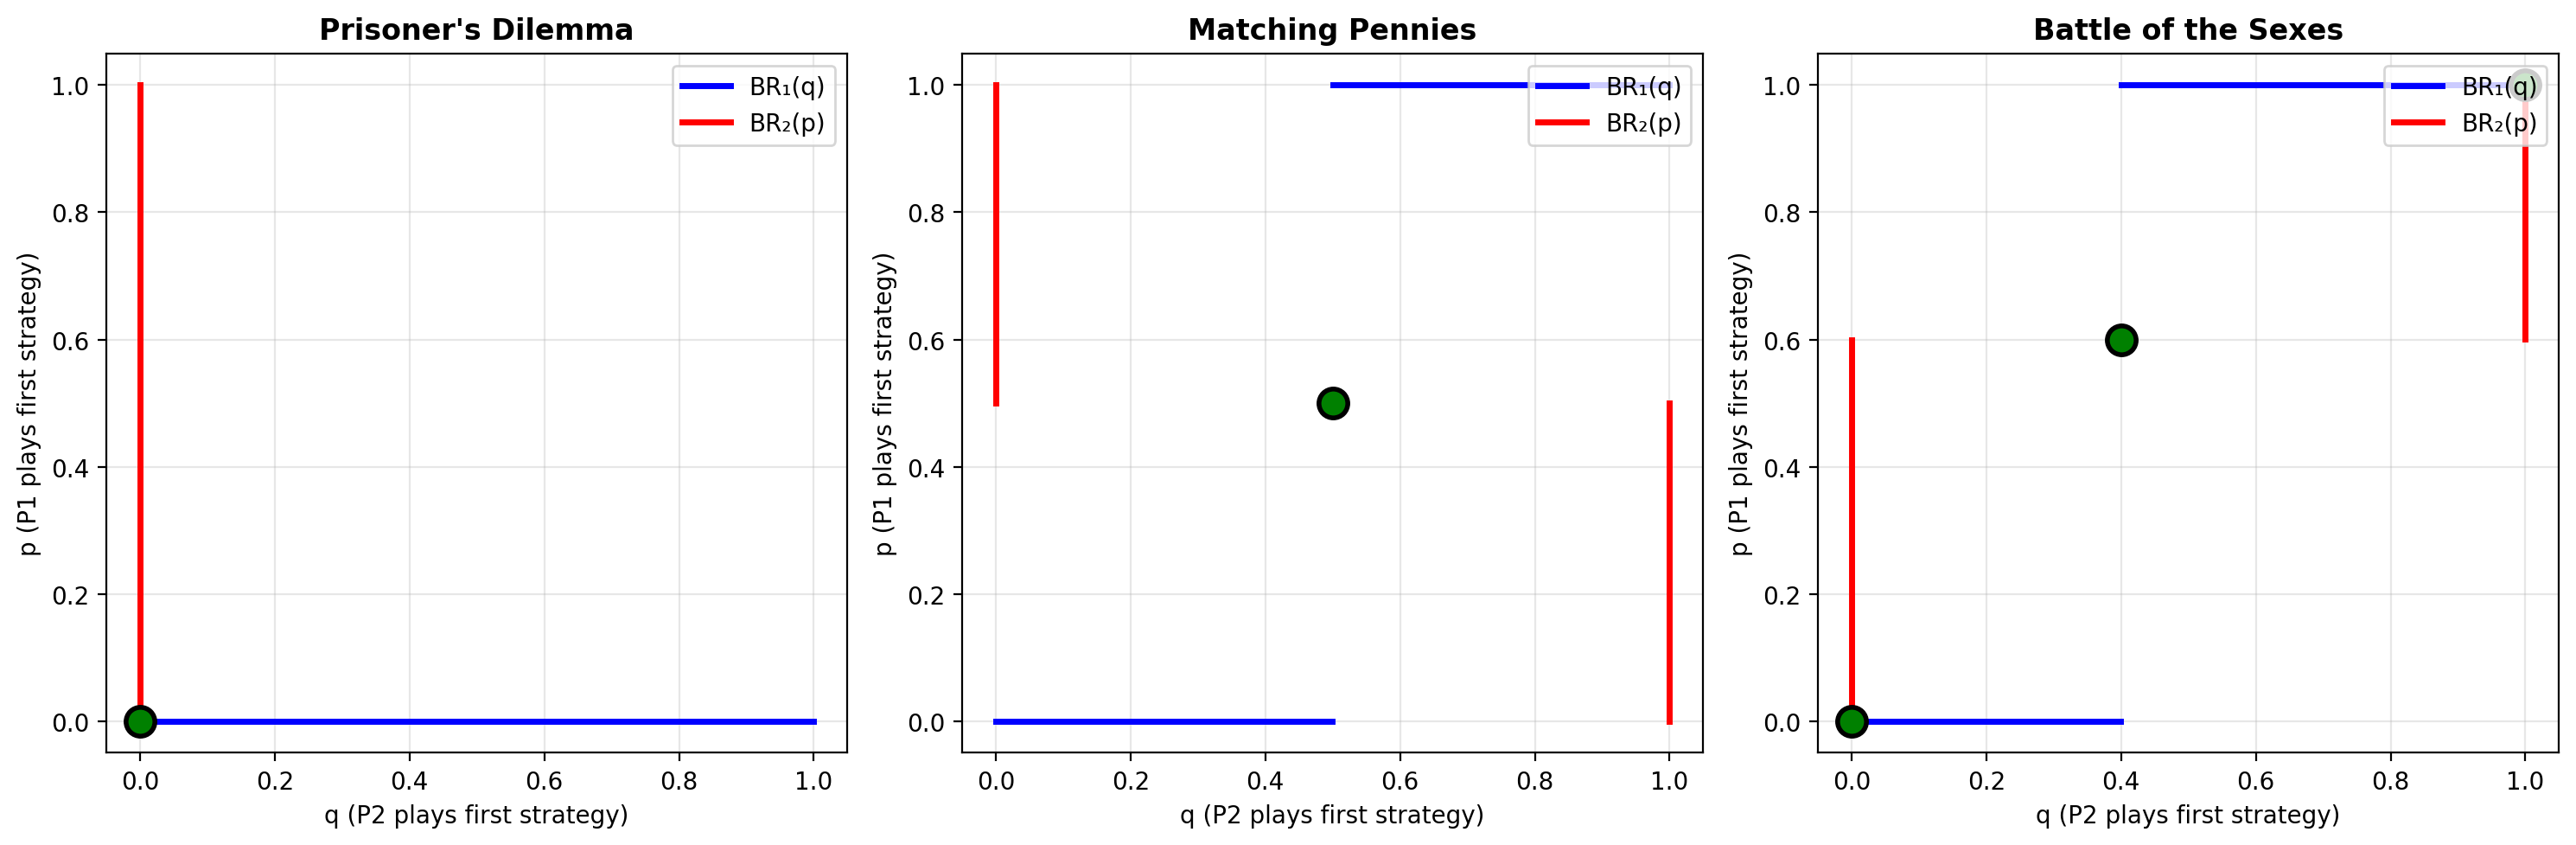


Visualization saved to plot.png


In [7]:
# Create visualization for all three games
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Prisoner's Dilemma
plot_best_responses(A_pd, B_pd, equilibria_pd, "Prisoner's Dilemma", axes[0])

# Matching Pennies
plot_best_responses(A_mp, B_mp, equilibria_mp, "Matching Pennies", axes[1])

# Battle of the Sexes
plot_best_responses(A_bos, B_bos, equilibria_bos, "Battle of the Sexes", axes[2])

plt.tight_layout()
plt.savefig('nash_equilibrium_finding_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to plot.png")

## Analysis of Results

### Prisoner's Dilemma
- **Unique Nash Equilibrium**: (Defect, Defect)
- Both players defecting is the only stable outcome, even though mutual cooperation would give both players higher payoffs
- This demonstrates the conflict between individual and collective rationality

### Matching Pennies
- **Unique Mixed Strategy Equilibrium**: Both players randomize 50-50
- No pure strategy equilibrium exists
- Expected payoff is 0 for both players

### Battle of the Sexes
- **Three Nash Equilibria**:
  1. (Opera, Opera) - Pure strategy, payoff (3, 2)
  2. (Football, Football) - Pure strategy, payoff (2, 3)
  3. Mixed strategy equilibrium
- Multiple equilibria create a coordination problem

## Larger Games: Rock-Paper-Scissors

Let's analyze a 3×3 game to demonstrate that our algorithm works for larger strategy spaces.

In [8]:
# Rock-Paper-Scissors
# Strategies: 0 = Rock, 1 = Paper, 2 = Scissors
A_rps = np.array([[0, -1, 1],
                   [1, 0, -1],
                   [-1, 1, 0]])
B_rps = -A_rps  # Zero-sum game

print("Rock-Paper-Scissors")
print("="*50)
print("\nPayoff Matrix for Player 1:")
print("              Rock  Paper  Scissors")
print(f"Rock           {A_rps[0,0]:2d}    {A_rps[0,1]:2d}       {A_rps[0,2]:2d}")
print(f"Paper          {A_rps[1,0]:2d}    {A_rps[1,1]:2d}       {A_rps[1,2]:2d}")
print(f"Scissors       {A_rps[2,0]:2d}    {A_rps[2,1]:2d}       {A_rps[2,2]:2d}")

equilibria_rps = find_nash_support_enumeration(A_rps, B_rps)
print(f"\nNash Equilibria found: {len(equilibria_rps)}")
for i, (p, q) in enumerate(equilibria_rps):
    print(f"\nEquilibrium {i+1}:")
    print(f"  Player 1: Rock={p[0]:.3f}, Paper={p[1]:.3f}, Scissors={p[2]:.3f}")
    print(f"  Player 2: Rock={q[0]:.3f}, Paper={q[1]:.3f}, Scissors={q[2]:.3f}")
    exp_payoff1 = p @ A_rps @ q
    exp_payoff2 = p @ B_rps @ q
    print(f"  Expected payoffs: ({exp_payoff1:.3f}, {exp_payoff2:.3f})")

Rock-Paper-Scissors

Payoff Matrix for Player 1:
              Rock  Paper  Scissors
Rock            0    -1        1
Paper           1     0       -1
Scissors       -1     1        0

Nash Equilibria found: 1

Equilibrium 1:
  Player 1: Rock=0.333, Paper=0.333, Scissors=0.333
  Player 2: Rock=0.333, Paper=0.333, Scissors=0.333
  Expected payoffs: (0.000, 0.000)


## Conclusion

We have implemented a support enumeration algorithm for finding Nash Equilibria in two-player games. Key takeaways:

1. **Nash Equilibrium** provides a solution concept where no player has incentive to deviate unilaterally

2. **Mixed strategies** extend the concept to allow randomization, guaranteeing existence in finite games (Nash's Theorem)

3. **Support enumeration** is an exact algorithm that finds all Nash Equilibria by systematically checking all possible support combinations

4. The **best response correspondence** visualization provides intuition about equilibrium structure in 2×2 games

5. Different game structures lead to different equilibrium patterns:
   - Dominant strategy equilibria (Prisoner's Dilemma)
   - Unique mixed equilibria (Matching Pennies, Rock-Paper-Scissors)
   - Multiple equilibria (Battle of the Sexes)

### Computational Complexity

The support enumeration algorithm has exponential complexity $O(2^{m+n})$ for a game with $m \times n$ strategies. For larger games, more sophisticated algorithms like the Lemke-Howson algorithm or polynomial-time approximation schemes are preferred.